# Background 
A mobile carrier has a more lucrative mobile plan that they want to recommend to the right customers. Provided data is subscriber behaviors who have already switched to the new plan. A classification model is needed to predict which customers can switched to a more expensive plan. 

# Understanding the data

In [2]:
import pandas as pd 
import numpy as np

df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

The classes are not balanced. There is an approximate 70/30 split between classes (not ultra/ultra). 

# Dataset splitting

In [11]:
from sklearn.model_selection import train_test_split
features = df.drop(['is_ultra'],axis=1)
target = df['is_ultra']

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, 
                                                                       test_size=0.25, random_state=12345) 
# 0.25 x 0.8 = 0.2

This method will split the dataframe into 60% training, 20% validation, 20% testing. The data did not seem abnormal to increase validation size, so I kept working with the typical ratio of data size.

# Model Training

### Decision Tree Classification

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

depth = []; train = []; valid = []
for depth_i in range(2,25,2):
    depth.append(depth_i)
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth_i)
    model.fit(features_train, target_train)
    train.append(model.score(features_train, target_train))
    print('[Training] Depth of ', depth_i, 'with model score of ', model.score(features_train, target_train))
    
    #model.fit(features_valid, target_valid) #Not suppose to refit the model. Ruins the point of validating the training 
    predictions_valid = model.predict(features_valid)
    print('     [Validation] Accuracy of', accuracy_score(target_valid, predictions_valid))
    valid.append(accuracy_score(target_valid, predictions_valid))


[Training] Depth of  2 with model score of  0.79201244813278
     [Validation] Accuracy of 0.7573872472783826
[Training] Depth of  4 with model score of  0.8205394190871369
     [Validation] Accuracy of 0.7636080870917574
[Training] Depth of  6 with model score of  0.8335062240663901
     [Validation] Accuracy of 0.7573872472783826
[Training] Depth of  8 with model score of  0.8661825726141079
     [Validation] Accuracy of 0.7667185069984448
[Training] Depth of  10 with model score of  0.8910788381742739
     [Validation] Accuracy of 0.7713841368584758
[Training] Depth of  12 with model score of  0.9154564315352697
     [Validation] Accuracy of 0.7558320373250389
[Training] Depth of  14 with model score of  0.9367219917012448
     [Validation] Accuracy of 0.7573872472783826
[Training] Depth of  16 with model score of  0.9512448132780082
     [Validation] Accuracy of 0.749611197511664
[Training] Depth of  18 with model score of  0.9642116182572614
     [Validation] Accuracy of 0.7418351

In [13]:
import seaborn as sns 
import matplotlib.pyplot as plt
TreeMetric = pd.DataFrame(list(zip(depth, train, valid)), columns =['depth_value', 'training', 'validation']) 
TreeMetric2 = pd.melt(TreeMetric, id_vars='depth_value', var_name="dataset_type", value_name="accuracy") #long data format 

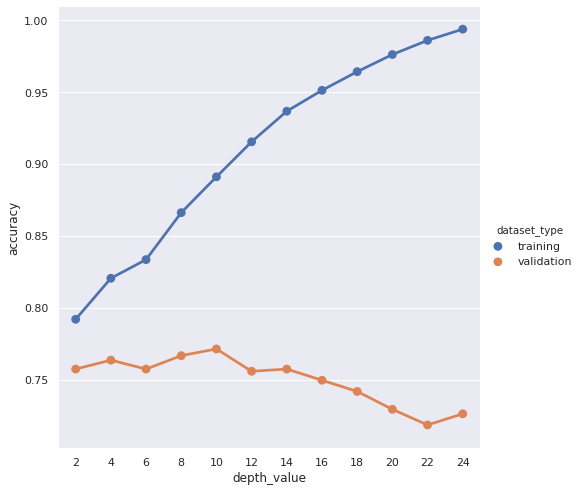

In [14]:
sns.set()
ax = sns.catplot(x = "depth_value", y = "accuracy", data = TreeMetric2, hue = "dataset_type", kind = "point", height = 7)
plt.show()

I tested both model.score and accuracy_score, and they appear to be having the same formula for the metric. Though, I did read that this metric depends depending on the model, but both should be okay for this simple classification. 

Using a decision tree with 60% of the source data as training data, the model was fit to said training data and was able to classify what type of internet service plan a customer should be placed in. The iterating through the max_depth hyperparameter from 2 - 22, we are able to see the full range of accuracy improvements. The accuracy change over different depth_values appears to fit a logarithmic curve, starting around 80% accuracy at depth 2 and near 100% accuracy at depth 24. 

Using 20% of the source data as a validation data set, we used the model fitted to the original training data to predict the classification of customer service plans for the validation dataset. Following the same max_depth iteration from 2 - 22, we see a negative slope curve. The range of accuracy for the validation data set starts around 76% at max_depth = 2 and around 73% at max_depth = 24. 

From depth_values 2 - 8, it appears that the training and validation datasets follows a positive slope in accuracy, but the training data set had a significantly higher slope. At depth_value = 8, the training and validation data set had a 10% difference in accuracy which I believe is an appropriate distinction before concern of overfitting comes in. The validation data set sees a peak at depth_value = 10, then continues to have a negative slope afterwards. All points after depth_value = 10 can have an argument of overfitting because the training model accuracy continued to have high accuracy, but had a difficult time understanding new data.  Seeing this difference in accuracy would prompt me to try different hyperparameters or models.

### Random Forest Classification

In [16]:
from sklearn.ensemble import RandomForestClassifier

depth = []; n_est =[]; train = []; valid = []
for depth_i in range(5,26,5):
    depth.append(depth_i)
    for n_esti in range(10,51,10):
        n_est.append(n_esti)
        model = RandomForestClassifier(random_state=12345, max_depth = depth_i, n_estimators = n_esti)
        model.fit(features_train, target_train)
        
        print('[Training] Depth of', depth_i, 'and n_estimators of', n_esti,
              'with model score of', model.score(features_train, target_train))
        train.append(model.score(features_train, target_train))
        print('     [Validation] model score of', model.score(features_valid, target_valid))
        valid.append(accuracy_score(target_valid, model.predict(features_valid)))
    print('-------------------------------------')

[Training] Depth of 5 and n_estimators of 10 with model score of 0.8283195020746889
     [Validation] model score of 0.7776049766718507
[Training] Depth of 5 and n_estimators of 20 with model score of 0.8319502074688797
     [Validation] model score of 0.7791601866251944
[Training] Depth of 5 and n_estimators of 30 with model score of 0.8319502074688797
     [Validation] model score of 0.7791601866251944
[Training] Depth of 5 and n_estimators of 40 with model score of 0.8319502074688797
     [Validation] model score of 0.7807153965785381
[Training] Depth of 5 and n_estimators of 50 with model score of 0.8324688796680498
     [Validation] model score of 0.7791601866251944
-------------------------------------
[Training] Depth of 10 and n_estimators of 10 with model score of 0.8884854771784232
     [Validation] model score of 0.7900466562986003
[Training] Depth of 10 and n_estimators of 20 with model score of 0.8890041493775933
     [Validation] model score of 0.7962674961119751
[Trainin

In [17]:
depth = np.repeat(depth,5)
n_est.extend(n_est)

ForestMetric = pd.DataFrame(list(zip(depth, train, valid)), columns =['depth_value','training', 'validation']) 
ForestMetric_long = pd.melt(ForestMetric, id_vars='depth_value', var_name="dataset_type", value_name="accuracy")
ForestMetric_long['n_est'] = n_est

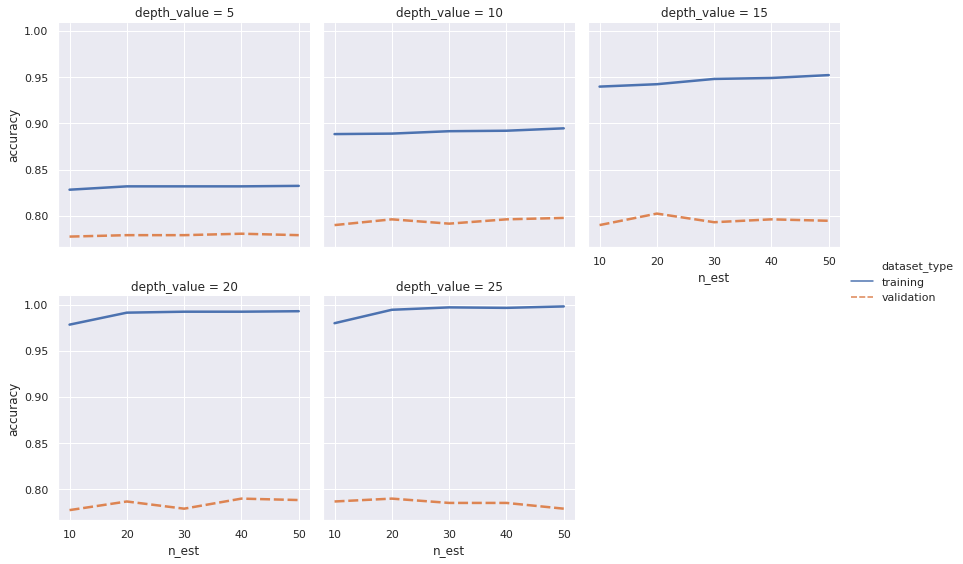

In [18]:
sns.relplot(x="n_est", y="accuracy", hue="dataset_type", style="dataset_type",
            col="depth_value", col_wrap=3,
            height=4, aspect=1, linewidth=2.5,
            kind="line", data=ForestMetric_long);

For this Random Forest Classifier model, I modified the hyperparameters depth_value and n_estimators from 5-25 and 10-50 respecitvely. Using 60% of the source data as a training data set, the model was fit to said data and was able to classify what type of internet service plan a customer should be placed in. We can see that depth_value has the greatest amount of change on the accuracy of training data where accuracy for the training started around 83% for depth_value = 5 and 97% for dpeth_value = 25. When it came to n_estimators, there is a very slight positive slope for accuracy increasing n_estimator. 

Using 20% of the source data as a validation data set, the model was tested on if it could accuracy classify customer service plans when it was fitted on the original training dataset. We saw that both depth_value and n_estimators had low strength in changing the accuracy of the validation data set. Through the different iterations of these hyperparameters, we saw that the validation accuracy ranged from 77% - 80%. The validation dataset saw it's peak accuracy during the combination of depth_value = 15 and n_est = 20. I would say that n_estimators would slightly increase accuracy, but we would see a negative slope in the higher depth_values. 

I would say the most accurate Random Forest Classifier model is with paramters depth_value = 5 and n_estimators = 40. The training accuracy is only 83%, but the accuracy difference between training and validation is not overly significant where it is obviously overfitted. 

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
solverList = ['lbfgs','liblinear','sag','saga']
train = []; valid = []
for i in range(len(solverList)):
    model = LogisticRegression(random_state=12345, solver=solverList[i], 
                               max_iter = 10000).fit(features_train, target_train)
    print('Solver:', solverList[i],',with model score of:', model.score(features_train, target_train))
    train.append(model.score(features_train, target_train))
    print('      [Validation],', model.score(features_valid, target_valid))
    valid.append(model.score(features_valid, target_valid))

Solver: lbfgs ,with model score of: 0.7510373443983402
      [Validation], 0.7262830482115086
Solver: liblinear ,with model score of: 0.703838174273859
      [Validation], 0.6967340590979783
Solver: sag ,with model score of: 0.6991701244813278
      [Validation], 0.6982892690513219
Solver: saga ,with model score of: 0.6991701244813278
      [Validation], 0.6998444790046656


In [20]:
LogisticMetric = pd.DataFrame(list(zip(solverList, train, valid)), columns =['solver', 'training', 'validation']) 
LogisticMetric2 = pd.melt(LogisticMetric, id_vars='solver', 
                          var_name="dataset_type", value_name="accuracy") #long data format 

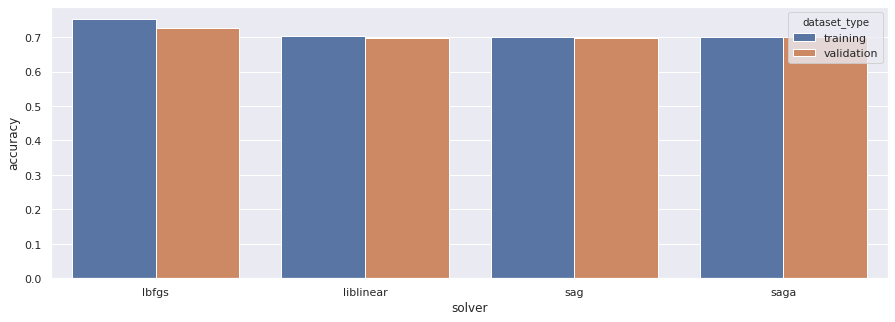

In [21]:
fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="solver", y="accuracy", hue="dataset_type", ax=ax,data=LogisticMetric2)

There were less parameters that I believe I could comfortable modify for this logistic regression model. I iterated through 4 different algorithm solvers used to solver for the classification of this model. All of the solvers produced above average accuracy, but most surprsingly, they produced accuracies that had minimal differences from the training and validation data sets. The largest accuracy difference was seen for the 'lbfgs' solver of about 2.5%. We actually saw the validation data set have a higher accuracy than the training dataset with the 'saga' solver. 

If I had to choose a solver to use, I would use 'lbfgs' because it produced the highest model accuracy for both training and validation. 

# Final Evaluation with the Test Data Set

Of the different models I have assessed, the one that produced the highest quality results was the random forest classifier. I am between using parameters max_depth = 5, n_estimators = 40 and max_depth = 20, n_estimators = 40 so I will model both and predict it with the test data set. 

I have picked these two different parameter sets because the first one had the smallest accuracy difference between training and validation datasets while producing high validation accuracy. The second parameter set produced the highest validation accuracy of all the models I have tested, so I wanted to see if there was a possibility if that metric would be the greatest determiner. 

In [22]:
model = RandomForestClassifier(random_state=12345, max_depth = 5, n_estimators = 40)
model.fit(features_train, target_train)

print('[Training] Depth of', depth_i, 'and n_estimators of', n_esti,
      'with model score of', model.score(features_train, target_train))
print('   [Validation] accuracy of', model.score(features_valid, target_valid))
print('      [Test] accuracy of', model.score(features_test, target_test))

[Training] Depth of 25 and n_estimators of 50 with model score of 0.8319502074688797
   [Validation] accuracy of 0.7807153965785381
      [Test] accuracy of 0.7916018662519441


In [23]:
model = RandomForestClassifier(random_state=12345, max_depth = 20, n_estimators = 40)
model.fit(features_train, target_train)

print('[Training] Depth of', depth_i, 'and n_estimators of', n_esti,
      'with model score of', model.score(features_train, target_train))
print('   [Validation] accuracy of', model.score(features_valid, target_valid))
print('      [Test] accuracy of', model.score(features_test, target_test))

[Training] Depth of 25 and n_estimators of 50 with model score of 0.9922199170124482
   [Validation] accuracy of 0.7900466562986003
      [Test] accuracy of 0.7776049766718507


It appears that the parameter set of max_depth = 20, n_estimators = 40 produced the highest accuracy of 79.16% when running the test dataset through the trained model. This has helped me understand that the model using the hyperparameters that has the smallest accuracy difference in training and validation while simultaneously producing high validation results is the more reliable classification model. 

# Sanity Check

In [24]:
sanity5050 = [0,1]
sanity5050 = np.repeat(sanity5050, (len(target_test)/2))
sanity5050 = np.append(sanity5050, 1)
sanity5050 = pd.DataFrame(sanity5050,  columns= ['is_ultra'])
model.score(features_test, sanity5050)

0.5318818040435459

<div class="alert alert-success" role="alert">
Here you can also predict constantly bigger class and your baseline score will become even better.</div>

Creating a dataframe named sanity5050 that was half '0' and half '1' for the 'is_ultra' column, we are able to check if our model is better than guessing. Using a model that was fitted under the training data and predicting the accuracy based on the features from the testing dataset, we are able to prove that the accuracy of using the "guessing" data set is about 50%. This shows that our model which produced an accuracy of 79% is in fact better than pure chance results.